In [70]:
from datasets import load_dataset

dataset = load_dataset('json', data_files={'train': 'train.jsonl','test':'validation.jsonl'})

In [76]:
import nltk

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')

vectorizer = CountVectorizer(max_features=512, min_df=4, max_df=0.7, stop_words=stopwords.words('english'))

X_train = vectorizer.fit_transform(dataset['train']['text'])

vocabulary = vectorizer.get_feature_names_out() 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aleksei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
from sklearn.feature_extraction.text import TfidfTransformer

X_test = vectorizer.transform(dataset['test']['text'])

tfidf = TfidfTransformer()

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.fit_transform(X_test)

In [80]:
X_train = X_train_tfidf.toarray()
X_test = X_test_tfidf.toarray()

y_train, y_test = dataset['train']['label'], dataset['test']['label']

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = X_train, X_test, dataset['train']['label'], dataset['test']['label']

X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [96]:
def blending(basic, meta, data):
    y = []
    
    for c in basic:
        y.append(c.predict(data))
    
    yt = np.array(y).transpose()
    
    return meta.predict(yt)


def make_stacking_prediction(basic_clfs, final_clf, data):
    y = []
    for c in basic_clfs:
        y.append(c.predict(data))
    y_t = np.array(y).transpose()
    return final_clf.predict(y_t)

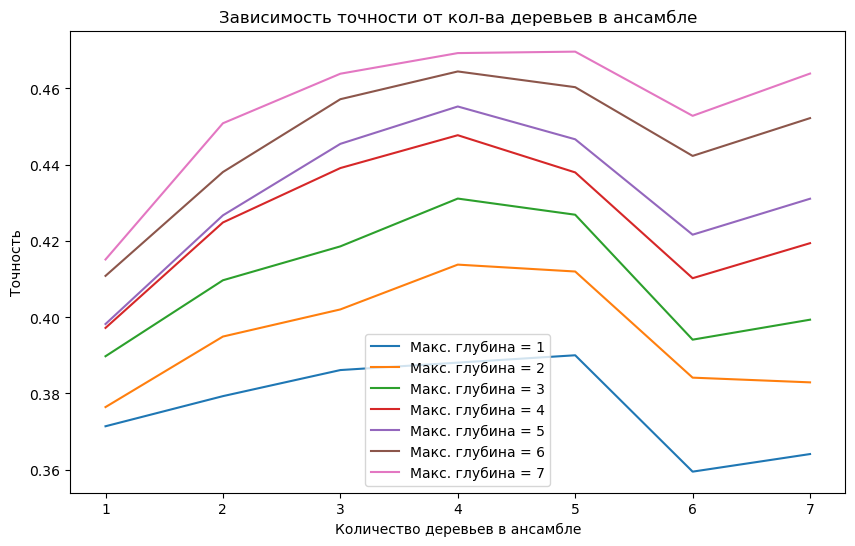

In [86]:
import matplotlib.pyplot as plot

from sklearn.ensemble import RandomForestClassifier
import random
from sklearn import metrics
import numpy as np
estimators = [i for i in range(1, 8)]
depths = [i for i in range(1, 8)]
ensembles = [i for i in range(1, 11)]
results = []
for e in estimators:
    for d in depths:
        predicted = []
        models = []
        for en in ensembles:
            clf = RandomForestClassifier(n_estimators=e, max_depth=d, random_state=en)
            clf.fit(X_train_0, y_train_0)
            models.append(clf)
            predicted.append(clf.predict(X_train_1).reshape(-1, 1))

        y_pred_1t = np.array(predicted).transpose()[0]
        
        for est in estimators:
            for de in depths:
                meta = RandomForestClassifier(n_estimators=est, max_depth=de, random_state=random.randint(0, 1000))
                meta.fit(y_pred_1t, y_train_1)

                y_test_pred = blending(models, meta, X_test)
                acc = metrics.accuracy_score(y_test, y_test_pred)
                
                results.append({
                    'e': e,
                    'd': d,
                    'est': est,
                    'de': de,
                    'acc': acc
                })
plot.figure(figsize=(10, 6))

for max_depth in depths:
    subset = [
        np.mean([r['acc'] for r in results
                if r['d'] == max_depth and r['e'] == n])
        for n in estimators
    ]
    plot.plot(estimators, subset, label=f'Макс. глубина = {max_depth}')

plot.xlabel('Количество деревьев в ансамбле')
plot.ylabel('Точность')
plot.title(f'Зависимость точности от кол-ва деревьев в ансамбле')
plot.legend()
plot.show()

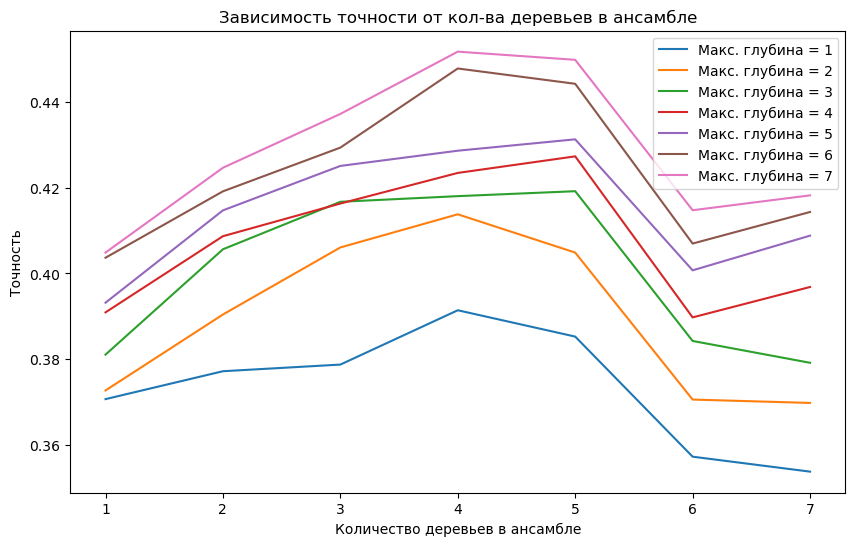

In [98]:
from sklearn.model_selection import KFold
import numpy

estimators = [i for i in range(1, 8)]
depths = [i for i in range(1, 8)]
ensembles = [i for i in range(1, 11)]
results = []

kFold = KFold(n_splits=10)

for e in estimators:
    for d in depths:
        pre_prediction = np.zeros((len(X_train), kFold.get_n_splits()))
        models = []
        for i, (train_index, test_index) in enumerate(kFold.split(X_train)):
            X_train_0, X_test_1 = np.array(X_train)[train_index], np.array(X_train)[test_index]
            y_train_0, y_test_1 = np.array(y_train)[train_index], np.array(y_train)[test_index]

            clf = RandomForestClassifier(n_estimators=e, max_depth=d, random_state=i)
            clf.fit(X_train_0, y_train_0)
            models.append(clf)
            pre_prediction[test_index, i] = clf.predict(X_test_1)
        
        for est in estimators:
            for de in depths:
                meta = RandomForestClassifier(n_estimators=est, max_depth=de, random_state=42)
                meta.fit(pre_prediction, y_train)

                y_test_pred = make_stacking_prediction(models, meta, X_test)
                acc = metrics.accuracy_score(y_test, y_test_pred)

                results.append({
                    'e': e,
                    'd': d,
                    'est': est,
                    'de': de,
                    'acc': acc
                })
plot.figure(figsize=(10, 6))

for d in depths:
    subset = [
        np.mean([r['acc'] for r in results
                if r['d'] == d and r['e'] == n])
        for n in estimators
    ]
    plot.plot(estimators, subset, label=f'Макс. глубина = {d}')

plot.xlabel('Количество деревьев в ансамбле')
plot.ylabel('Точность')
plot.title(f'Зависимость точности от кол-ва деревьев в ансамбле')
plot.legend()
plot.show()

In [99]:
from sklearn.datasets import load_iris

iris = load_iris()

X = iris.data[:, 2:]
y = iris.target

target_names = iris.target_names
feature_names = iris.feature_names[2:]

[Text(0.4, 0.8333333333333334, 'x[0] <= 2.45\nentropy = 1.585\nsamples = 150\nvalue = [50, 50, 50]\nclass = setosa'),
 Text(0.2, 0.5, 'entropy = 0.0\nsamples = 50\nvalue = [50, 0, 0]\nclass = setosa'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'x[1] <= 1.75\nentropy = 1.0\nsamples = 100\nvalue = [0, 50, 50]\nclass = versicolor'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'entropy = 0.445\nsamples = 54\nvalue = [0, 49, 5]\nclass = versicolor'),
 Text(0.8, 0.16666666666666666, 'entropy = 0.151\nsamples = 46\nvalue = [0, 1, 45]\nclass = virginica')]

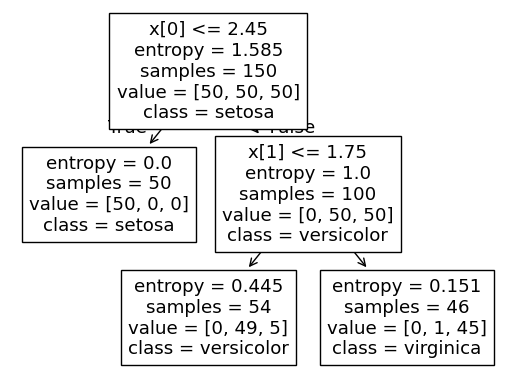

In [100]:
from sklearn import tree


tree_clf_gini = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=2, random_state=42)
tree_clf_gini.fit(X, y)

tree.plot_tree(tree_clf_gini, class_names = target_names)

In [101]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

In [118]:
import pandas as pd

train = pd.read_csv('departure-delayed/train_features.csv').fillna(0)
y = pd.read_csv('departure-delayed/train_target.csv', index_col='id')
train.drop('Year', axis=1, inplace=True)

train = train[list(train.dtypes[train.dtypes != 'object'].index.values)]

In [120]:
x_train, x_val, y_train, y_val = train_test_split(train, y, train_size=0.8, test_size=0.2, random_state=42)

mae = []
mae_train = []

min_samples_leaf_values = range(1, 101)

for min_samples_leaf in min_samples_leaf_values:
    model = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf, random_state=42)
    model.fit(x_train, y_train)
    mae_train.append(mean_absolute_error(y_train, model.predict(x_train)))
    mae.append(mean_absolute_error(y_val, model.predict(x_val)))

In [121]:

x_train, x_val, y_train, y_val = train_test_split(train, y, train_size=0.8, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=min_samples_leaf, random_state=42)
model.fit(x_train, y_train)

print(mean_absolute_error(model.predict(x_val), y_val))

33.665006553117635


In [122]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

bag_of_trees = BaggingRegressor(model, n_estimators=5, random_state=42)

bag_of_trees.fit(x_train, y_train)

C:\Users\Aleksei\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=5,
                                                 min_samples_leaf=100,
                                                 random_state=42),
                 n_estimators=5, random_state=42)

In [123]:
from sklearn.model_selection import GridSearchCV

y_train_flat = y_train.values.ravel() # чтобы точно был одномерный массив

params = {
    'n_estimators': [4, 6, 8, 10],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

bagging_regressor = BaggingRegressor(estimator=model, random_state=42, n_jobs=-1)

grid_search = GridSearchCV(bagging_regressor, params, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_search.fit(x_train, y_train_flat)

print(f'params: {grid_search.best_params_}')
print(f'MAE: {grid_search.best_score_}')

params: {'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 8}
MAE: -33.577509269141814


In [124]:
forest = RandomForestRegressor(n_estimators=5, n_jobs=-1, random_state=42, criterion='squared_error', max_depth=9)
forest.fit(x_train, y_train)
rf_mse_val = mean_absolute_error(forest.predict(x_val), y_val)
print(rf_mse_val)

C:\Users\Aleksei\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


33.21772406454778


In [125]:
params = {
    'n_estimators': [4, 6, 8, 10],
    'max_depth': [None, 4, 6, 8],
    'max_features': ['auto', 'sqrt', 'log2']
}

forest_regressor = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(forest_regressor, params, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_search.fit(x_train, y_train_flat)

print(f'params: {grid_search.best_params_}')
print(f'MAE: {grid_search.best_score_}')

C:\Users\Aleksei\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
48 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Aleksei\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Aleksei\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\Aleksei\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Aleksei\anaconda3\Lib\sit

params: {'max_depth': 8, 'max_features': 'log2', 'n_estimators': 8}
MAE: -33.39800170180205


#### Trees

In [32]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, roc_auc_score
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


In [34]:
from sklearn.datasets import load_iris

iris = load_iris()

X = iris.data[:, 2:]
y = iris.target

target_names = iris.target_names
feature_names = iris.feature_names[2:]

[Text(0.4, 0.8333333333333334, 'x[0] <= 2.45\nentropy = 1.585\nsamples = 150\nvalue = [50, 50, 50]\nclass = setosa'),
 Text(0.2, 0.5, 'entropy = 0.0\nsamples = 50\nvalue = [50, 0, 0]\nclass = setosa'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'x[1] <= 1.75\nentropy = 1.0\nsamples = 100\nvalue = [0, 50, 50]\nclass = versicolor'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'entropy = 0.445\nsamples = 54\nvalue = [0, 49, 5]\nclass = versicolor'),
 Text(0.8, 0.16666666666666666, 'entropy = 0.151\nsamples = 46\nvalue = [0, 1, 45]\nclass = virginica')]

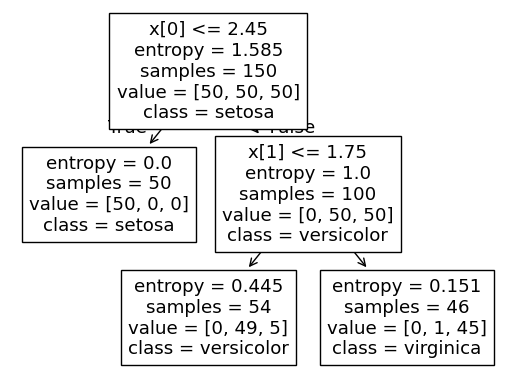

In [36]:
from sklearn import tree


tree_clf_gini = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=2, random_state=42)
tree_clf_gini.fit(X, y)

tree.plot_tree(tree_clf_gini, class_names = target_names)

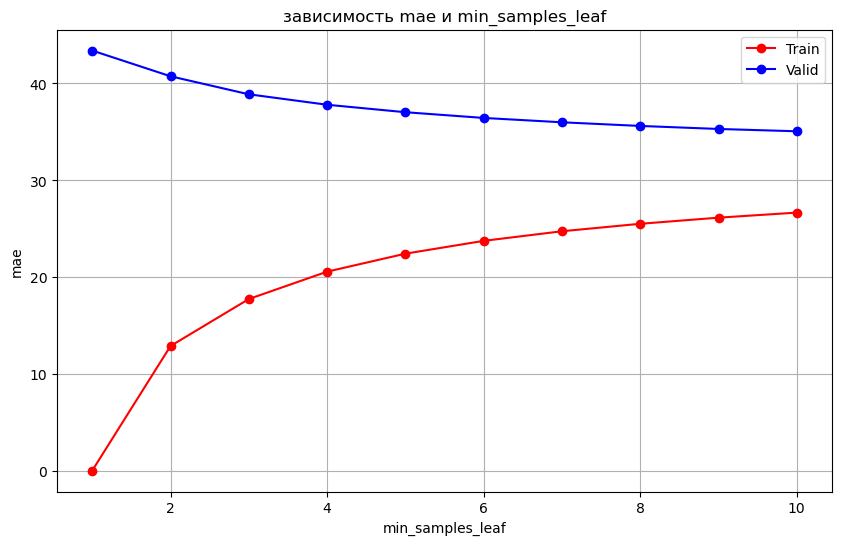

In [46]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

train = pd.read_csv('departure-delayed/train_features.csv').fillna(0)
y = pd.read_csv('departure-delayed/train_target.csv', index_col='id')

train.drop('Year', axis=1, inplace=True)

real_columns = list(train.dtypes[train.dtypes != 'object'].index.values)

x_train, x_val, y_train, y_val = train_test_split(train[real_columns], y, train_size=0.8, test_size=0.2, random_state=42)

min_samples_leaf_values = range(1, 11)

mae = []
mae_train = []

for min_samples_leaf in min_samples_leaf_values:
    model = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf, random_state=42)
    model.fit(x_train, y_train)
    mae_train.append(mean_absolute_error(y_train, model.predict(x_train)))
    mae.append(mean_absolute_error(y_val, model.predict(x_val)))

plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf_values, mae_train, label='Train', marker='o', linestyle='-', color='r')
plt.plot(min_samples_leaf_values, mae, label='Valid', marker='o', linestyle='-', color='b')
plt.title('зависимость mae и min_samples_leaf')
plt.legend()
plt.xlabel('min_samples_leaf')
plt.ylabel('mae')
plt.grid(True)  
plt.show()

In [52]:
def train_model_with_best_parameters(x, y, max_depth, max_samples_leaf):
    x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)

    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)

    model.fit(x_train, y_train)

    return x_train, x_val, y_train, y_val, model, mean_absolute_error(model.predict(x_val), y_val)

In [54]:
x_train, x_val, y_train, y_val, best_model, mae = train_model_with_best_parameters(train[real_columns], y, 21, 1000)

print(f'МАЕ модели с лучшими параметрами: {mae}')

МАЕ модели с лучшими параметрами: 33.66618994431758


In [56]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

bag_of_trees = BaggingRegressor(best_model, n_estimators=5, random_state=42)

bag_of_trees.fit(x_train, y_train)

C:\Users\Aleksei\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=21,
                                                 min_samples_leaf=10,
                                                 random_state=42),
                 n_estimators=5, random_state=42)

In [66]:
from sklearn.model_selection import GridSearchCV

y_train_flat = y_train.values.ravel() # чтобы точно был одномерный массив

param_grid = {
    'n_estimators': [4, 6, 8],
    'max_samples': [0.5, 0.8],
    'max_features': [0.5, 0.8]
}

bagging_regressor = BaggingRegressor(estimator=best_model, random_state=42, n_jobs=-1)

grid_search = GridSearchCV(bagging_regressor, param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_search.fit(x_train, y_train_flat)

print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучший MAE: {grid_search.best_score_}')

Лучшие параметры: {'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 8}
Лучший MAE: -32.61761697253288


In [68]:
forest = RandomForestRegressor(n_estimators=5, n_jobs=-1, random_state=42, criterion='squared_error', max_depth=9)
forest.fit(x_train, y_train)
rf_mse_val = mean_absolute_error(forest.predict(x_val), y_val)
rf_mse_val

C:\Users\Aleksei\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


33.21772406454778